In [1]:
from sqlalchemy import create_engine
engine = create_engine("sqlite:///hawaii.sqlite")

In [2]:
from sqlalchemy.ext.automap import automap_base
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurements', 'stations']

In [3]:
Measurement = Base.classes.measurements
Station = Base.classes.stations

In [4]:
from sqlalchemy import inspect
inspector = inspect(engine)

In [5]:
columns = inspector.get_columns('measurements')
for column in columns:
    print(column["name"], column["type"])
    
columns = inspector.get_columns('stations')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station VARCHAR
date VARCHAR
prcp FLOAT
tobs INTEGER
id INTEGER
station VARCHAR
name VARCHAR
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [6]:
from sqlalchemy.orm import Session
session = Session(engine)

results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-23').all()

In [7]:
import pandas as pd
barplot_df = pd.DataFrame(results, columns=['date', 'precipitation'])
barplot_df.head()

,date,precipitation
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01


In [8]:
xticks = ['']
x = 0
for i in range(11):
    xticks.append(barplot_df.iloc[x,0])
    x += 32

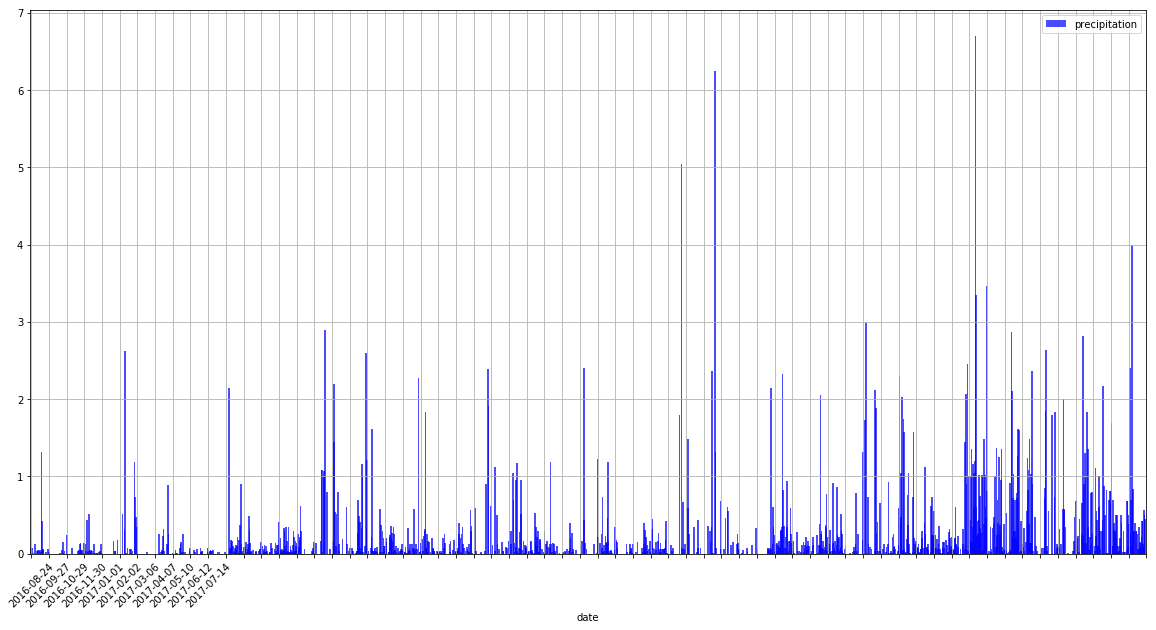

In [9]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
ax = barplot_df.plot(kind='bar', x='date', y='precipitation',
                     color="blue", alpha=0.7, 
                     width=3, figsize=(20,10), 
                     grid=True, legend=True, rot=45)

ax.set_xticklabels(xticks)
ax.xaxis.set_major_locator(ticker.MultipleLocator(32))

plt.show()

In [10]:
barplot_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [11]:
from sqlalchemy import func
from sqlalchemy import distinct
session.query(func.count(distinct(Measurement.station)))[0][0]

9

In [12]:
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    all()

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [13]:
results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').all()

histplot_df = pd.DataFrame(results, columns=['tobs'])

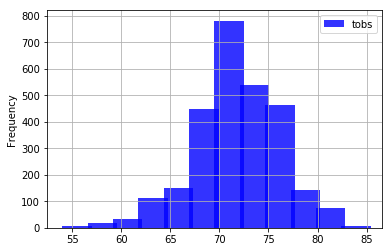

In [14]:
ax = histplot_df.plot(kind='hist', y='tobs', 
                      color="blue", alpha=0.8, 
                      width=3,
                      bins=12, range=(histplot_df['tobs'].min(),histplot_df['tobs'].max()),
                      grid=True, legend=True)

plt.show()

In [15]:
#results = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == 'USC00519281').all()
#barchart_df = pd.DataFrame(results, columns=['date', 'tobs'])
#barchart_df['date'] = pd.to_datetime(barchart_df['date'])
#barchart_df.head()

In [16]:
def calc_temps(start_date, end_date):   #%Y-%m-%d
    
    maxtemp = session.query(func.max(Measurement.tobs)).\
        filter(Measurement.date >= '2017-01-01').\
        filter(Measurement.date <= '2017-01-31').\
        filter(Measurement.station == 'USC00519281').all()

    mintemp = session.query(func.min(Measurement.tobs)).\
        filter(Measurement.date >= '2017-01-01').\
        filter(Measurement.date <= '2017-01-31').\
        filter(Measurement.station == 'USC00519281').all()

    avgtemp = session.query(func.avg(Measurement.tobs)).\
        filter(Measurement.date >= '2017-01-01').\
        filter(Measurement.date <= '2017-01-31').\
        filter(Measurement.station == 'USC00519281').all()
        
    return(maxtemp[0][0], mintemp[0][0], avgtemp[0][0])

In [17]:
# calc_temps('2016-08-01', '2017-07-31')
peak2peak = calc_temps('2016-08-01', '2017-07-31')[0] - calc_temps('2016-08-01', '2017-07-31')[1]

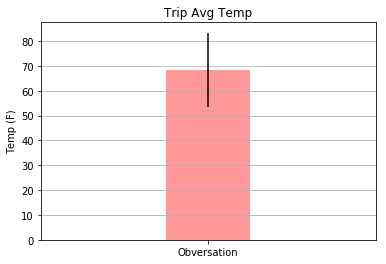

In [18]:
plt.bar('Obversation', calc_temps('2016-08-01', '2017-07-31')[2], 
        color="red", alpha=0.4, width = .5,
        yerr=peak2peak)

plt.xlim(-1,1)
plt.grid(axis='y')
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')

plt.show()

In [19]:
session.query(Measurement.station, func.avg(Measurement.prcp)).\
    filter(Measurement.date.like('%-01-01')).\
    group_by(Measurement.station).all()

[('USC00511918', 0.008333333333333333),
 ('USC00513117', 0.14875),
 ('USC00514830', 0.028000000000000004),
 ('USC00516128', 0.06999999999999999),
 ('USC00518838', 0.21),
 ('USC00519281', 0.12375000000000001),
 ('USC00519397', 0.0125),
 ('USC00519523', 0.08142857142857143)]

In [20]:
def daily_normals(mmdd, station): # 'USC00519281'
    
    likedate = '%-' + mmdd
    
    max_temp = session.query(func.max(Measurement.tobs)).\
        filter(Measurement.date.like(likedate)).\
        filter(Measurement.station == station).all()
        
    min_temp = session.query(func.min(Measurement.tobs)).\
        filter(Measurement.date.like(likedate)).\
        filter(Measurement.station == station).all()
        
    avg_temp = session.query(func.avg(Measurement.tobs)).\
        filter(Measurement.date.like(likedate)).\
        filter(Measurement.station == station).all()
        
    return (mmdd, max_temp[0][0], min_temp[0][0], avg_temp[0][0])

In [21]:
# daily_normals('01-01', 'USC00519281')

datelist = ['01-01', '01-02', '01-03', '01-04', '01-05', '01-06', '01-07']
templist = []

for dates in datelist:
    templist.append(daily_normals(dates, 'USC00519281')) 
    
areaplot_df = pd.DataFrame(templist, columns=['mmdd', 'tmax', 'tmin', 'tavg'])
areaplot_df.set_index('mmdd')

,tmax,tmin,tavg
mmdd,,,
01-01,77,66,71.500
01-02,74,60,68.750
01-03,74,63,67.875
01-04,75,63,68.500
01-05,74,56,66.375
01-06,76,62,67.500
01-07,76,63,68.875


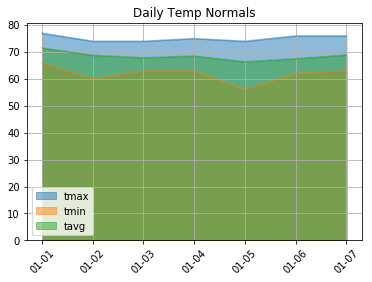

In [22]:
ax = areaplot_df.plot(kind='area',
                 stacked=False, 
                 grid=True, 
                 title='Daily Temp Normals')

xticks = [""] + datelist
ax.set_xticklabels(xticks, rotation=45)

plt.show()